This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below. 

I have simplier model with 
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
#added
datafolder="input/"
trainfolder=datafolder+"train/"
testfolder=datafolder+"test1"
print(os.listdir(datafolder))


['sampleSubmission.csv', 'dogs-vs-cats.zip', 'test1', 'test1.zip', 'train', 'train.zip']


# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
filenames = os.listdir(trainfolder)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat.9206.jpg,0
1,dog.10483.jpg,1
2,cat.2858.jpg,0
3,cat.2937.jpg,0
4,cat.6228.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.7427.jpg,1
24996,dog.1567.jpg,1
24997,cat.7479.jpg,0
24998,cat.2260.jpg,0
24999,cat.1025.jpg,0


### See Total In count

<AxesSubplot:>

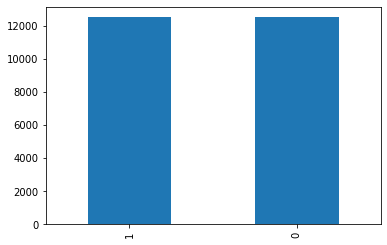

In [6]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

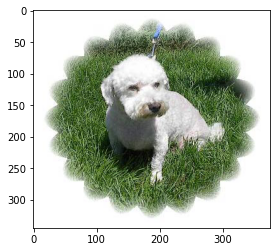

In [7]:
sample = random.choice(filenames)
image = load_img(trainfolder+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

# Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [11]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

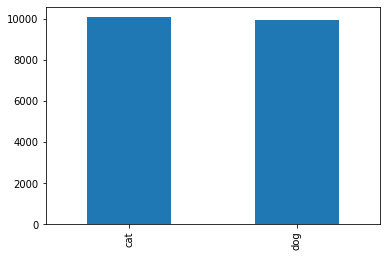

In [16]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

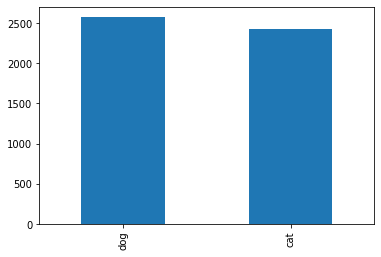

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    trainfolder, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    trainfolder, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    trainfolder, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


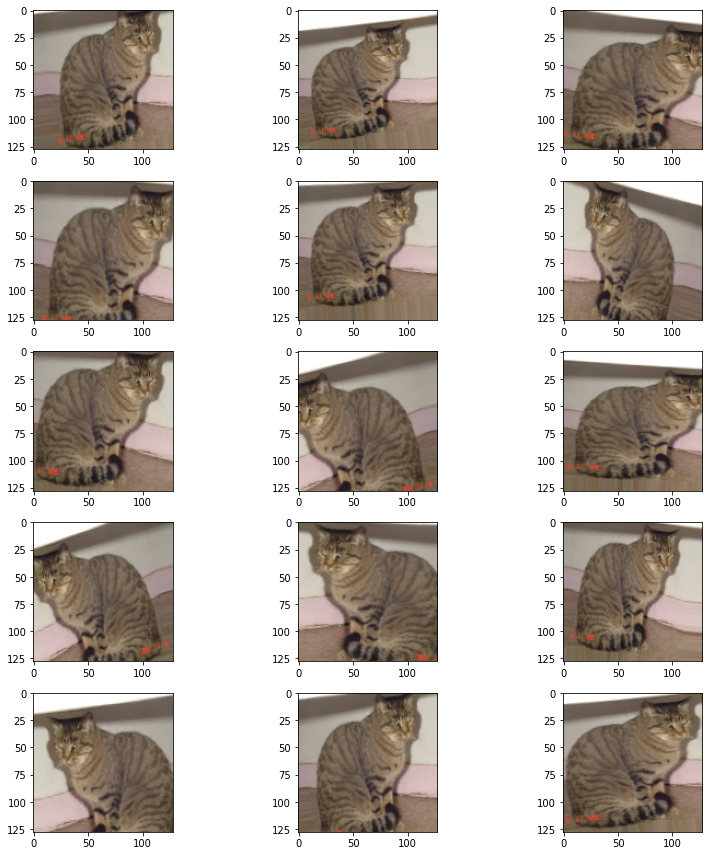

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [23]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 242s 182ms/step - loss: 0.7068 - accuracy: 0.6373 - val_loss: 0.5791 - val_accuracy: 0.6941
Epoch 2/50
1333/1333 [==============================] - 110s 82ms/step - loss: 0.5367 - accuracy: 0.7311 - val_loss: 0.5426 - val_accuracy: 0.7009
Epoch 3/50
1333/1333 [==============================] - 109s 82ms/step - loss: 0.4826 - accuracy: 0.7680 - val_loss: 1.2017 - val_accuracy: 0.5367
Epoch 4/50
1333/1333 [==============================] - 110s 82ms/step - loss: 0.4479 - accuracy: 0.7908 - val_loss: 0.6546 - val_accuracy: 0.7728
Epoch 5/50
1333/1333 [==============================] - 110s 82ms/step - loss: 0.4231 - accuracy: 0.8051 - val_loss: 0.6946 - val_accuracy: 0.7664
Epoch 6/50
1333/1333 [==============================] - 110s 82ms/step - loss: 0.4009 - accuracy: 0.8188 - val_loss: 0.4226 - val_accuracy: 0.7990
Epoch 7/50
1333/1333 [==============================] - 110s 82ms/step - loss: 0.3800 - accuracy: 0.8297 - val_loss: 

# Save Model

In [24]:
model.save_weights("model.h5")

# Virtualize Training

KeyError: 'acc'

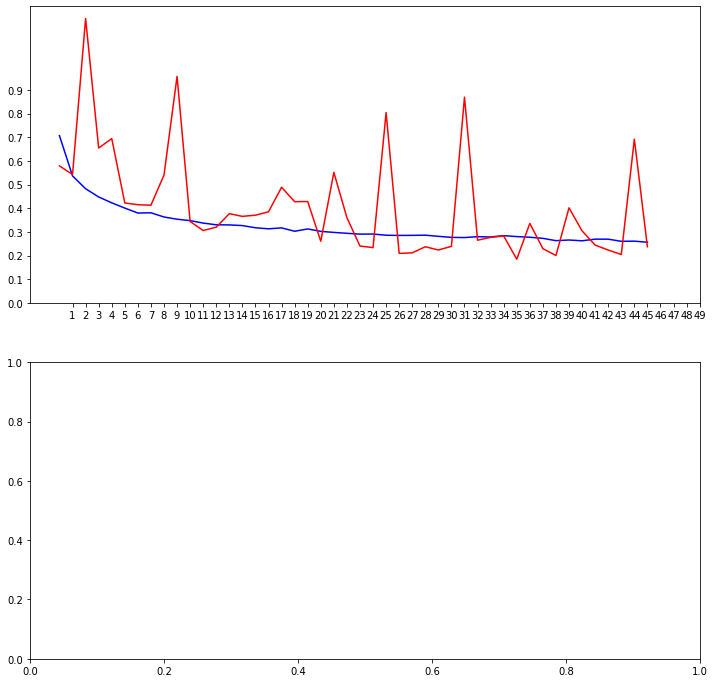

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [27]:
test_filenames = os.listdir(testfolder)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    testfolder, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [29]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(testfolder+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)